In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.ttbar.preselection.Run2_UL18
module

/store/user/ekoenig/TTAnalysis/NTuples/2018/preselection/Run2_UL/RunIISummer20UL18NanoAODv9
   QCD
   TTJets

In [4]:
def use_file(f):
    return f.replace('ntuple_0.root', 'ntuple_1.root')
ttbar = ObjIter([Tree( [use_file(f) for f in module.TTToHadronic] )])
# qcd = ObjIter([Tree(module.Run2_UL18.QCD_B_List)])

def use_file(f):
    return f.replace('ntuple.root', 'ntuple_1.root')
qcd = ObjIter([Tree([ use_file(f) for f in module.QCD_B_List ] )])

100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


In [5]:
ttbar[0].is_signal = True

In [6]:
def reconstruct_ttbar(jet_p4, comb):
    b_p4  = jet_p4[comb[:,::3]]
    wj1 = jet_p4[comb[:,1::3]]
    wj2 = jet_p4[comb[:,2::3]]
    w_p4 = wj1 + wj2
    t_p4 = b_p4 + w_p4

    t_pt_sort = ak.argsort(t_p4.pt, axis=1, ascending=False)
    t_p4 = t_p4[t_pt_sort]
    b_p4 = b_p4[t_pt_sort]
    w_p4 = w_p4[t_pt_sort]
    wj1 = wj1[t_pt_sort]
    wj2 = wj2[t_pt_sort]
    

    return dict(
        **{
            f't_{field}':getattr(t_p4,field)
            for field in ('pt','m','eta','phi')
        },
        **{
            f'W_{field}':getattr(w_p4,field)
            for field in ('pt','m','eta','phi')
        },
        **{
            f'W_j1_{field}':getattr(wj1,field)
            for field in ('pt','m','eta','phi','btag','signalId')
        },
        **{
            f'W_j2_{field}':getattr(wj2,field)
            for field in ('pt','m','eta','phi','btag','signalId')
        },
        **{
            f'b_{field}':getattr(b_p4,field)
            for field in ('pt','m','eta','phi','btag','signalId')
        },
    )

In [7]:
import utils.ttbarUtils.models as ttbar_models


def load_ranker_reco(t, model):
    ranker = eightb.load_weaver_output(t, model=model, fields=['maxcomb','maxscore'])


    jet_p4 = build_p4(t, prefix='jet', extra=['btag','signalId'])
    combs = ak.from_regular( ranker['maxcomb'].astype(int) )
    t.extend(
        **reconstruct_ttbar(jet_p4, combs)
    )

In [8]:
(ttbar + qcd).apply(lambda t : load_ranker_reco(t, model=ttbar_models.feynnet_bool_btag_bkg.path))

ValueError: need at least one array to concatenate

100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


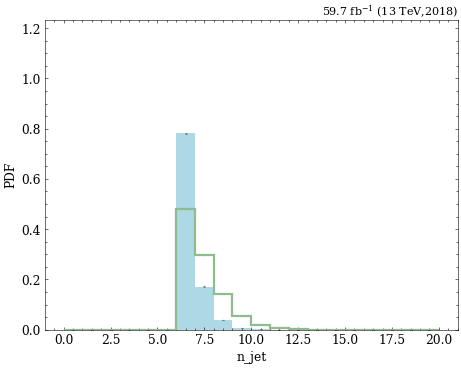

In [ ]:
study.quick(
    ttbar+qcd,
    varlist=['n_jet'],
    efficiency=True,
)

In [ ]:
((t - 172)/35)**2 + ((w - 81)/15)**2

100%|██████████| 2/2 [00:12<00:00,  6.09s/it]


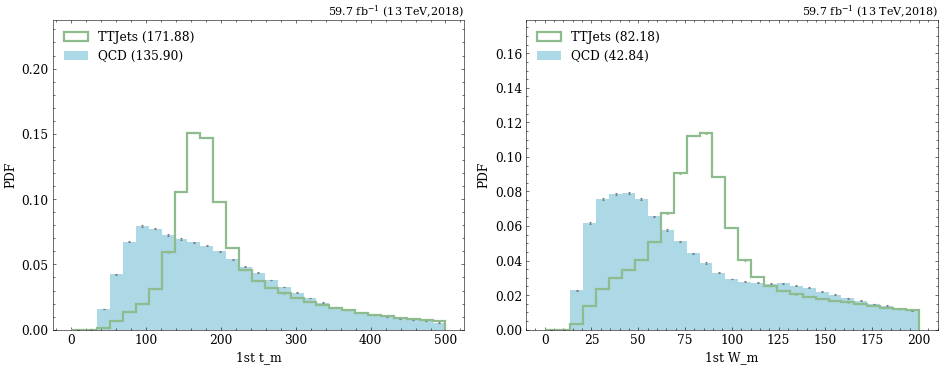

In [ ]:
study.quick(
    ttbar+qcd,
    legend=True,
    h_fit='gaussian',h_fit_peak=True,
    h_label_stat='{fit.mu:0.2f}',
    varlist=['t_m[:,0]','W_m[:,0]'],
    binlist=[(0,500,30),(0,200,30)],
    efficiency=True,
)

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


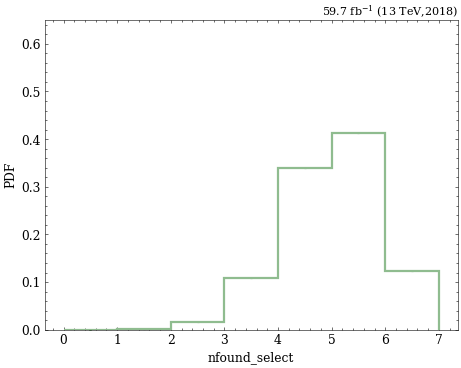

In [ ]:
study.quick(
    ttbar,
    varlist=['nfound_select'],
    efficiency=True,
)

100%|██████████| 2/2 [00:11<00:00,  5.59s/it]


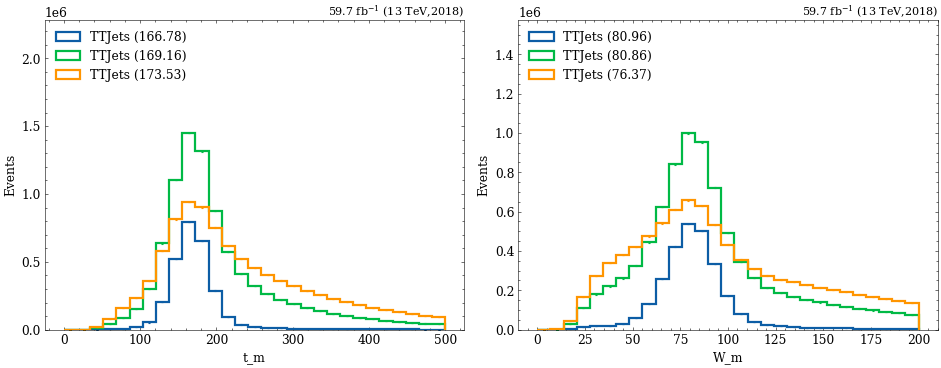

In [ ]:
study.quick(
    ttbar[[0,0,0]],
    h_color=None,
    masks=[lambda t : t.nfound_select==6,lambda t:t.nfound_select==5,lambda t:t.nfound_select<5,],
    legend=True,
    h_fit='gaussian',h_fit_peak=True,
    h_label_stat='{fit.mu:0.2f}',
    varlist=['t_m','W_m'],
    binlist=[(0,500,30),(0,200,30)],
    # efficiency=True,
)

In [ ]:
def get_reco_id(t):

    b_id = t.b_signalId
    w1_id = t.W_j1_signalId
    w2_id = t.W_j2_signalId
    b_id = ak.where( ((b_id+3) % 3) == 0, b_id//3, -1 )
    w_id = ak.where( (w1_id//3) == (w2_id//3), w1_id//3, -1 )
    t_id = ak.where( b_id == w_id, b_id, -1)
    reco_id = 1* ak.all(t_id > -1, axis=1)

    t.extend(
        reco_id = 1*(ak.all(t_id > -1, axis=1))
    )
ttbar.apply(get_reco_id)

[None]

In [ ]:
sixj_ttbar = ttbar.apply(EventFilter('six_jets', filter=lambda t:t.nfound_select==6))

In [ ]:
def btag_multi(t):
    t.extend(
        n_loose_btag = ak.sum( t.jet_btag>jet_btagWP[1], axis=1),
        n_medium_btag = ak.sum( t.jet_btag>jet_btagWP[2], axis=1),
        n_tight_btag = ak.sum( t.jet_btag>jet_btagWP[3], axis=1),
    )
sixj_ttbar.apply(btag_multi)

[None]

100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


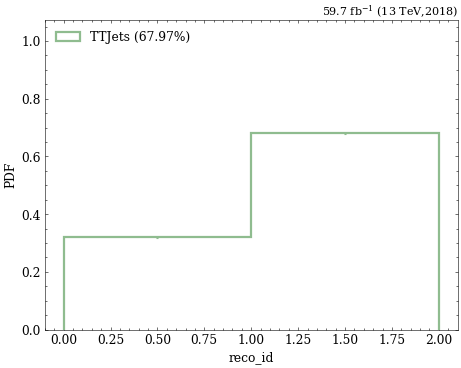

In [ ]:
study.quick(
    sixj_ttbar,
    masks=lambda t: t.n_loose_btag==2,
    varlist=['reco_id'],
    efficiency=True,
    
    legend=True,
    h_label_stat=lambda h:f'{h.histo[-1]:0.2%}',
)

100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


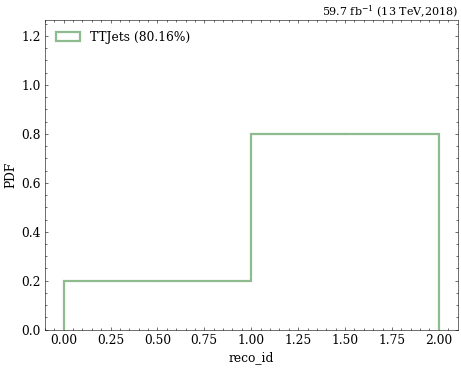

In [24]:
study.quick(
    sixj_ttbar,
    masks=lambda t: (t.n_medium_btag==2),
    varlist=['reco_id'],
    efficiency=True,
    
    legend=True,
    h_label_stat=lambda h:f'{h.histo[-1]:0.2%}',
)

100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


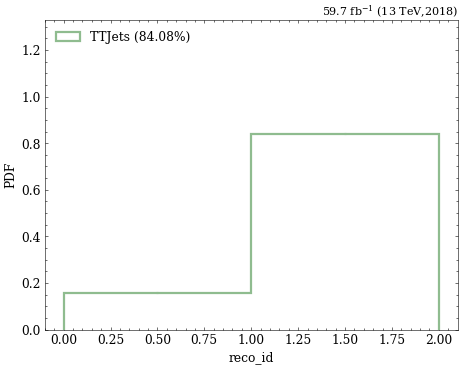

In [25]:
study.quick(
    sixj_ttbar,
    masks=lambda t: (t.n_tight_btag==2),
    varlist=['reco_id'],
    efficiency=True,
    
    legend=True,
    h_label_stat=lambda h:f'{h.histo[-1]:0.2%}',
)